In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2025-sep-dl-gen-ai-project/sample_submission.csv
/kaggle/input/2025-sep-dl-gen-ai-project/train.csv
/kaggle/input/2025-sep-dl-gen-ai-project/test.csv


# Loading the datasets

In [2]:
train = pd.read_csv('/kaggle/input/2025-sep-dl-gen-ai-project/train.csv')
test = pd.read_csv('/kaggle/input/2025-sep-dl-gen-ai-project/test.csv')

# Importing important libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# EDA

In [4]:
train.info

<bound method DataFrame.info of         id                                               text  anger  fear  \
0        0  the dentist that did the work apparently did a...      1     0   
1        1  i'm gonna absolutely ~~suck~~ be terrible duri...      0     1   
2        2  bridge: so leave me drowning calling houston, ...      0     1   
3        3  after that mess i went to see my now ex-girlfr...      1     1   
4        4  as he stumbled i ran off, afraid it might some...      0     1   
...    ...                                                ...    ...   ...   
6822  6822  there is not a cloud in the sky and the sun is...      0     0   
6823  6823                             &gt; the grave stomper      0     0   
6824  6824                   my ear was still freaking stuck.      1     1   
6825  6825  i felt like there was an electric current flow...      0     1   
6826  6826         i read everything i could get my hands on.      0     0   

      joy  sadness  surprise   

In [5]:
train.describe()

,id,anger,fear,joy,sadness,surprise
count,6827.000000,6827.000000,6827.000000,6827.000000,6827.000000,6827.000000
mean,3413.000000,0.118354,0.565402,0.243152,0.318002,0.292808
std,1970.929476,0.323050,0.495740,0.429018,0.465734,0.455084
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1706.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3413.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,5119.500000,0.000000,1.000000,0.000000,1.000000,1.000000
max,6826.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
train.sample(10)

,id,text,anger,fear,joy,sadness,surprise,emotions
750,750,she lifted my other hand to examine the pads o...,0,0,0,0,0,[]
6717,6717,legal counsel recommended i not try to take he...,1,1,0,1,0,['anger' 'fear' 'sadness']
1939,1939,i hear it's muffled cries as he tried to stran...,1,1,0,1,1,['anger' 'fear' 'sadness' 'surprise']
1614,1614,my arms are also a little upset with me after ...,0,1,0,0,0,['fear']
1960,1960,"( you see, i have these afi patches that i bou...",0,0,1,0,0,['joy']
4970,4970,i had never been so scared.,0,1,0,0,0,['fear']
6530,6530,my disbelief was outstanding.,0,0,0,0,1,['surprise']
6435,6435,then i looked in the mirror and my eyes fell d...,0,1,0,1,0,['fear' 'sadness']
1392,1392,"this is typical, as they need to justify their...",1,0,0,0,0,['anger']
6500,6500,"this morning i cut my fingers on a hole punch,...",0,1,0,1,0,['fear' 'sadness']


In [7]:
train.isnull().sum()

id          0
text        0
anger       0
fear        0
joy         0
sadness     0
surprise    0
emotions    0
dtype: int64

In [8]:
train.nunique()

id          6827
text        4986
anger          2
fear           2
joy            2
sadness        2
surprise       2
emotions      29
dtype: int64

In [9]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain columns:", train.columns.tolist())
print("\nSample rows from train:")
display(train.head())

# Missing values check
print("\nMissing values in train:")
print(train.isnull().sum())

print("\nMissing values in test:")
print(test.isnull().sum())

Train shape: (6827, 8)
Test shape: (1707, 2)

Train columns: ['id', 'text', 'anger', 'fear', 'joy', 'sadness', 'surprise', 'emotions']

Sample rows from train:


,id,text,anger,fear,joy,sadness,surprise,emotions
0,0,the dentist that did the work apparently did a...,1,0,0,1,0,['anger' 'sadness']
1,1,i'm gonna absolutely ~~suck~~ be terrible duri...,0,1,0,1,0,['fear' 'sadness']
2,2,"bridge: so leave me drowning calling houston, ...",0,1,0,1,0,['fear' 'sadness']
3,3,after that mess i went to see my now ex-girlfr...,1,1,0,1,0,['anger' 'fear' 'sadness']
4,4,"as he stumbled i ran off, afraid it might some...",0,1,0,0,0,['fear']



Missing values in train:
id          0
text        0
anger       0
fear        0
joy         0
sadness     0
surprise    0
emotions    0
dtype: int64

Missing values in test:
id      0
text    0
dtype: int64


In [10]:
print(train.columns.tolist())

['id', 'text', 'anger', 'fear', 'joy', 'sadness', 'surprise', 'emotions']


**Distribution of emotion labels**

fear        3860
sadness     2171
surprise    1999
joy         1660
anger        808
dtype: int64


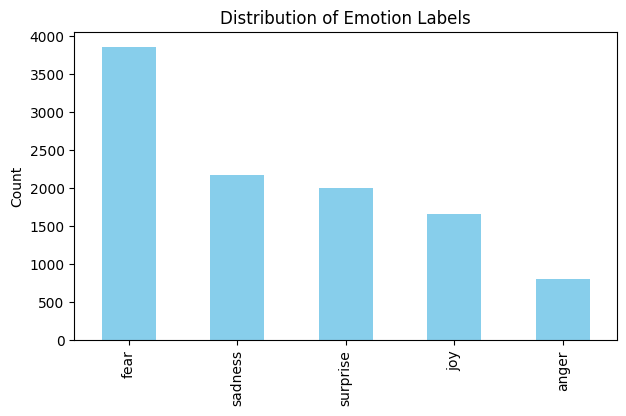

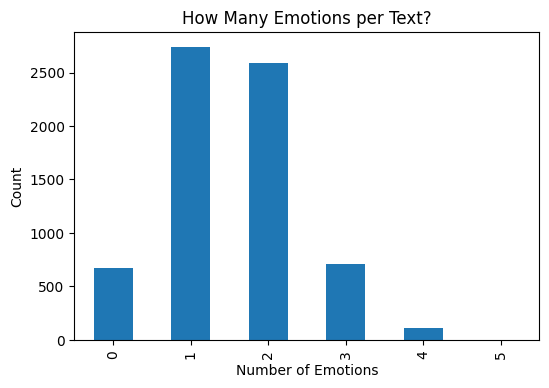

In [11]:
emotion_cols = ['anger', 'fear', 'joy', 'sadness', 'surprise']

# Total label counts
label_counts = train[emotion_cols].sum().sort_values(ascending=False)
print(label_counts)

# Plot
plt.figure(figsize=(7,4))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotion Labels')
plt.ylabel('Count')
plt.show()

# Number of emotions per text
train['num_labels'] = train[emotion_cols].sum(axis=1)
plt.figure(figsize=(6,4))
train['num_labels'].value_counts().sort_index().plot(kind='bar')
plt.title('How Many Emotions per Text?')
plt.xlabel('Number of Emotions')
plt.ylabel('Count')
plt.show()

**Text length distribution**

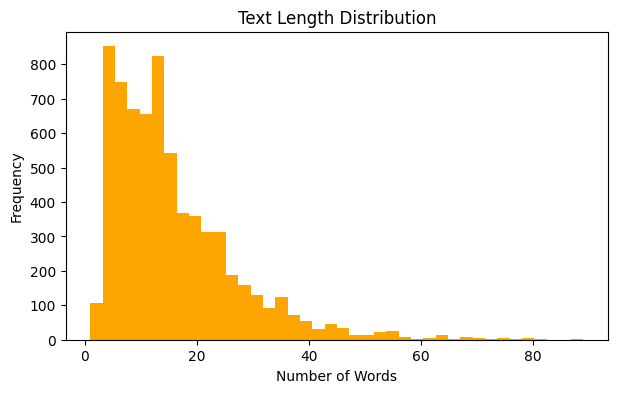


Average words per text: 15.684781016551927
Max words: 89
Min words: 1


In [12]:
train['text_length'] = train['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(7,4))
plt.hist(train['text_length'], bins=40, color='orange')
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

print("\nAverage words per text:", train['text_length'].mean())
print("Max words:", train['text_length'].max())
print("Min words:", train['text_length'].min())

**Examples of various emotions:**

In [13]:
for emotion in emotion_cols:
    print(f"\n--- Examples for {emotion} ---")
    samples = train[train[emotion]==1]['text'].head(3).tolist()
    for s in samples:
        print("-", s)


--- Examples for anger ---
- the dentist that did the work apparently did a lousy job as in just a few years my teeth decayed under the crowns so i had no choice but to get partials.
- after that mess i went to see my now ex-girlfriend at school because she refused to drive home to see me.
- so i was like "wtf, you have the bag, read the bag.

--- Examples for fear ---
- i'm gonna absolutely ~~suck~~ be terrible during my first sexual experience ._.
- bridge: so leave me drowning calling houston, and let my lungs cave in, from calling god, for my mistakes and to the one who deserves the apology.
- after that mess i went to see my now ex-girlfriend at school because she refused to drive home to see me.

--- Examples for joy ---
- he put a huge grin on my face.
- drawing my arm out from under me i push against him and adjust myself so that i am able to sit up and stare at him, playfully swatting at his stomach.
- the insides of my eyelids flashed bright colors, all my muscles constricte

**Heatmap:**

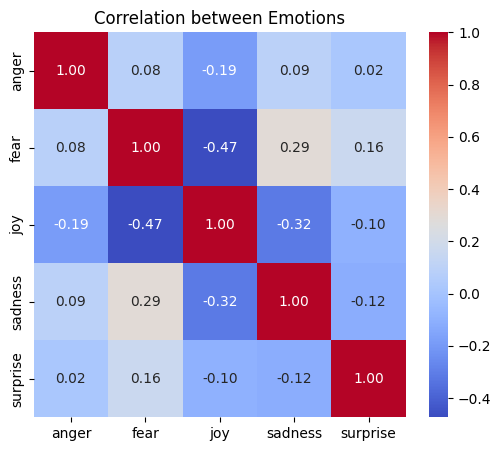

In [14]:
# Correlation between labels
corr = train[emotion_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Emotions")
plt.show()

# Preprocessing

In [15]:
import re
import string


train['text'].head(10)


0    the dentist that did the work apparently did a...
1    i'm gonna absolutely ~~suck~~ be terrible duri...
2    bridge: so leave me drowning calling houston, ...
3    after that mess i went to see my now ex-girlfr...
4    as he stumbled i ran off, afraid it might some...
5                       he put a huge grin on my face.
6    i notice the small surprises and accidents in ...
7    drawing my arm out from under me i push agains...
8    turning to face the mirror, with his feet in t...
9    so anyways it's late at night and i was down i...
Name: text, dtype: object

**Text cleaning:**

In [16]:
def clean_text(text):
    """
    Basic text cleaning that removes noise but keeps emotional cues.
    """
    text = str(text).lower()
    
    # removing URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # removing user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # removing extra spaces and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    
    # removing numbers if not useful
    text = re.sub(r'\d+', '', text)
    
    return text

**Applying the cleaning:**

In [17]:
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

**Checking results:**

In [18]:
print("Before cleaning:")
print(train['text'].iloc[500])
print("\nAfter cleaning:")
print(train['clean_text'].iloc[500])

Before cleaning:
" so i will remain positive for as long as i live.

After cleaning:
" so i will remain positive for as long as i live.


**Comaring lengths (before and after):**

In [19]:
train['clean_length'] = train['clean_text'].apply(lambda x: len(x.split()))

print("\nAverage length before cleaning:", train['text_length'].mean())
print("Average length after cleaning:", train['clean_length'].mean())


Average length before cleaning: 15.684781016551927
Average length after cleaning: 15.63453932913432


# Building a model with RoBERTa tokenizer

In [20]:
!pip install transformers accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

2025-11-09 23:26:59.226081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762730819.408138      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762730819.460970      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
tokenizer = RobertaTokenizer.from_pretrained(
    "roberta-base",
    local_files_only=False,
    trust_remote_code=True
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

**Preparing data:**

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    train['text'].values,
    train[emotion_cols].values,
    test_size=0.1,
    random_state=42
)

**Creating dataset class:**

In [24]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )

        item = {key: torch.tensor(val) for key, val in inputs.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

**Creating dataloaders:**

In [25]:
train_dataset = EmotionDataset(X_train, y_train, tokenizer)
val_dataset = EmotionDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

**Loading Pretrained BERT:**

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(emotion_cols),
    problem_type="multi_label_classification"
)
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

**Training setup:**

In [27]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 10

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

**Training the model:**

In [28]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in progress:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_loss:.4f}")

Epoch 1: 100%|██████████| 384/384 [00:44<00:00,  8.72it/s]


Average training loss: 0.4522


Epoch 2: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


Average training loss: 0.3090


Epoch 3: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


Average training loss: 0.2379


Epoch 4: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


Average training loss: 0.1864


Epoch 5: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


Average training loss: 0.1502


Epoch 6: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


Average training loss: 0.1248


Epoch 7: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


Average training loss: 0.1049


Epoch 8: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


Average training loss: 0.0895


Epoch 9: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]


Average training loss: 0.0795


Epoch 10: 100%|██████████| 384/384 [00:43<00:00,  8.84it/s]

Average training loss: 0.0735


# Validation

In [29]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(val_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.sigmoid(outputs.logits).cpu().numpy()
        labels = batch['labels'].cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels)

preds_binary = (np.array(predictions) > 0.5).astype(int)
print(classification_report(np.array(true_labels), preds_binary, target_names=emotion_cols))

100%|██████████| 43/43 [00:01<00:00, 28.33it/s]

              precision    recall  f1-score   support

       anger       0.87      0.81      0.84        80
        fear       0.91      0.91      0.91       392
         joy       0.87      0.87      0.87       163
     sadness       0.89      0.84      0.86       210
    surprise       0.89      0.86      0.88       201

   micro avg       0.89      0.87      0.88      1046
   macro avg       0.88      0.86      0.87      1046
weighted avg       0.89      0.87      0.88      1046
 samples avg       0.80      0.78      0.78      1046



# Submission

In [30]:
test_dataset = EmotionDataset(test['text'].values, labels=None, tokenizer=tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
test_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        outputs = model(**batch)
        preds = torch.sigmoid(outputs.logits).cpu().numpy()
        test_preds.extend(preds)

test_preds = np.array(test_preds)
test_preds_binary = (test_preds > 0.5).astype(int)

submission = pd.DataFrame(test_preds_binary, columns=emotion_cols)
submission['id'] = test['id']
submission.to_csv('submission.csv', index=False)
submission.head()

100%|██████████| 107/107 [00:03<00:00, 28.79it/s]


,anger,fear,joy,sadness,surprise,id
0,1,0,0,0,0,0
1,0,0,0,0,0,1
2,1,1,0,0,0,2
3,0,1,0,0,0,3
4,0,1,0,0,1,4
